In [14]:
%load_ext autoreload
%autoreload 2
import os
os.chdir(os.path.dirname(os.getcwd()))
import numpy as np
import matplotlib.pyplot as plt
from approx_Schuster import *
from CPW.cpw import *
import scipy.io as sc
import scipy.signal as sig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulations OneResonator tests (2024/04/11)

In [13]:
path = r'C:\Users\miguelcarrerab\Documents\GitHub\resonators\mat_files\OneResonator'
file_list = os.listdir(path)
print(file_list)
d_OR = {}

# Load the data
for file in file_list:
    name = file.split('.')[0]
    file_path = os.path.join(path, file)
    mat_contents = sc.loadmat(file_path)
    freq = mat_contents['X\x00\x00\x00\x00\x00\x00\x00'][0]
    if name[0] != 'Z':
        y_name = 'amp'
    else:
        y_name = 'imp'
        
    y_data = mat_contents['Y\x00\x00\x00\x00\x00\x00\x00'][0]
    d_OR[name] = {'freq': freq, y_name: y_data}
    



['CPW_100pH.mat', 'CPW_50pH.mat', 'CPW_5pH.mat', 'S21_100pH.mat', 'S21_50pH.mat', 'S21_5pH.mat', 'Z_100pH.mat', 'Z_50pH.mat', 'Z_5pH.mat']


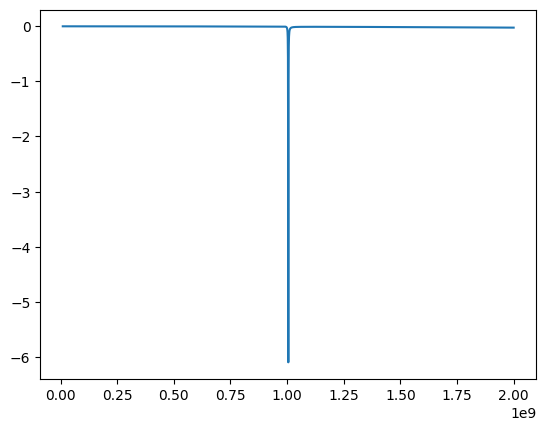

In [178]:
# Remove second peak from 100pH spectrum
freq = d_OR['S21_100pH']['freq']
new_freq = []
new_amp = []
for i,f in enumerate(freq):
    if f < 2e9:
        new_freq.append(f)
        new_amp.append(d_OR['S21_100pH']['amp'][i])

d_OR['S21_100pH']['amp'] = np.array(new_amp)
d_OR['S21_100pH']['freq'] = np.array(new_freq)

# Plot the data
plt.plot(d_OR['S21_100pH']['freq'],d_OR['S21_100pH']['amp'])



### Resonator characterization

In [185]:
def impedance_resonator(w, Cc, L, C):
    return 1j*w*Cc + (1j*w*C + 1/(1j*w*L))**(-1)

def db(x):
    return 20*np.log10(x)

def linear(x):
    return 10**(x/20)

def impedance_resonator_from_S21(S21, Z0):
    S21 = linear(S21)
    return Z0*S21/(2*(1-S21))

def w0_from_S21(S21, w, prominence):
    dip , _ = sig.find_peaks(-S21, prominence = prominence)
    w0 = w[dip[0]]
    return w0

def Qe_from_S21(S21, w, prominence):
    w0 = w0_from_S21(S21, w, prominence)
    S21 = 1-linear(S21)
    S21 = S21 - np.min(S21)
    # a,b = np.polyfit(w, S21, 1)
    # S21_nomr = -S21 + a*w + b
    max_S21 = np.max(S21)
    fwhm = np.abs(w[w > w0][np.argmin(np.abs(S21[w > w0] - max_S21/2))]-w[w < w0][np.argmin(np.abs(S21[w < w0] - max_S21/2))])
    return w0/fwhm



5pH

0.0062203534541082385
29207


(6.2855289352991655, 6.348700080377548)

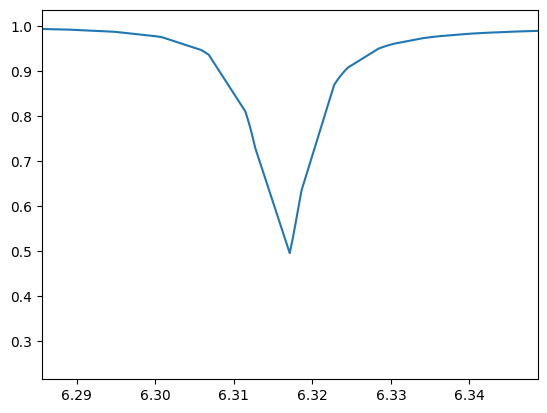

In [180]:
fwhm_100pH = 1e-9*w0_100pH/Qe_100pH
print(fwhm_100pH)
x1 = w0_100pH - fwhm_100pH/2
x2 = w0_100pH + fwhm_100pH/2
S21_min = np.min(linear(d_OR['S21_100pH']['amp']))
plt.hlines((1-S21_min)/2, x1*1e-9, x2*1e-9)

plt.plot(d_OR['S21_100pH']['freq']*2*np.pi*1e-9,linear(d_OR['S21_100pH']['amp']))
i = 0
for w in w_100pH:
    if w < 0.995*w0_100pH or w > 1.005*w0_100pH:
        i += 1
print(i)
plt.xlim(0.995*w0_100pH*1e-9, 1.005*w0_100pH*1e-9)

In [186]:
w_5pH = d_OR['S21_5pH']['freq']*2*np.pi
w0_5pH = w0_from_S21(d_OR['S21_5pH']['amp'], w_5pH, 10)
Qe_5pH= Qe_from_S21(d_OR['S21_5pH']['amp'], w_5pH, 10)
Zr_5pH_from_S21 = impedance_resonator_from_S21(d_OR['S21_5pH']['amp'], 50)


w_50pH = d_OR['S21_50pH']['freq']*2*np.pi
w0_50pH = w0_from_S21(d_OR['S21_50pH']['amp'], w_50pH, 10)
Qe_50pH = Qe_from_S21(d_OR['S21_50pH']['amp'], w_50pH, 10)
Zr_50pH_from_S21 = impedance_resonator_from_S21(d_OR['S21_50pH']['amp'], 50)

w_100pH = d_OR['S21_100pH']['freq']*2*np.pi
w0_100pH = w0_from_S21(d_OR['S21_100pH']['amp'], w_100pH, 1)
Qe_100pH= Qe_from_S21(d_OR['S21_100pH']['amp'], w_100pH, 1)
Zr_100pH_from_S21 = impedance_resonator_from_S21(d_OR['S21_100pH']['amp'], 50)



print(w0_5pH*1e-9/(2*np.pi), w0_50pH*1e-9/(2*np.pi), w0_100pH*1e-9/(2*np.pi))
print(Qe_5pH, Qe_50pH, Qe_100pH)


4.08384 1.4164200000000002 1.0054000000000003
598.8035190615968 753.4148936170789 1015.5555555554826


Get Cc from Z_r

In [187]:
Cc_5 = 1/(Zr_5pH_from_S21[0]*w_5pH[0])
print(Cc_5*1e15)
Cc_50 = 1/(Zr_50pH_from_S21[0]*w_50pH[0])
print(Cc_50*1e15)
Cc_100 = 1/(Zr_100pH_from_S21[0]*w_100pH[0])
print(Cc_100*1e15)


0.8982801460756403
30.848890987477684
37.18869271985493


Get C_r from Qe

In [191]:
Cc_5

8.982801460756403e-16

In [194]:
Cr_5 = Qe_5pH*50*w0_5pH*Cc_5**2
print(Cr_5*1e15)
Cr_50 = Qe_50pH*50*w0_50pH*Cc_50**2-Cc_50
print(Cr_50*1e15)
Cr_100 = Qe_100pH*50*w0_100pH*Cc_100**2-Cc_100
print(Cr_100*1e15)

0.6199069952888214
288.19852821073374
406.43452131858203


In [106]:
length_ind = 3144e-6
width_ind = 1e-6
Lk = 100e-12
C_s100 = 1/(w0_100pH**2*Lk*length_ind/width_ind)
print(C_s100*1e15)

79.70397188802959


In [107]:
length_ind = 3144e-6
width_ind = 1e-6
Lk = 50e-12
C_s50 = 1/(w0_50pH**2*Lk*length_ind/width_ind)
print(C_s50*1e15)

80.3162865938717


In [102]:
L_50pH = 1/(80.3162865938717e-15*(w0_50pH)**2)
print(L_50pH*1e9)
L_100pH = 1/(79.7039718880295e-15*(w0_100pH)**2)
print(L_100pH*1e9)

157.20000000000005
314.40000000000043


0.8982801460756403
0.24486757561510733
30.848890987477684
0.007060052809195014
37.18869271985493
0.009946290033817385


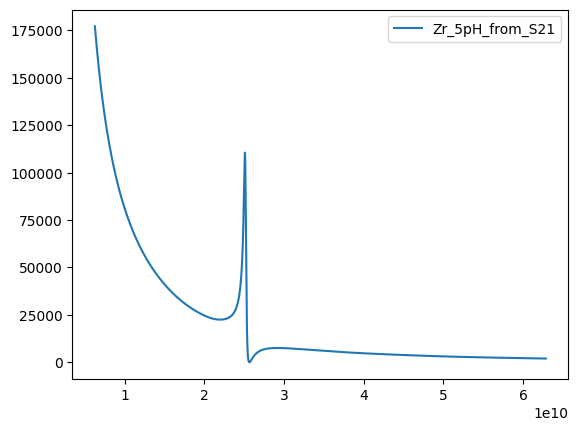

In [104]:
imp_res = np.abs(impedance_resonator(w_5pH, 5e-15, 50e-15, 5e-8))

plt.plot(w_5pH, Zr_5pH_from_S21, label = 'Zr_5pH_from_S21')
plt.legend()
# plt.plot(w_5pH, imp_res, label = 'imp_res')
# plt.plot(w_5pH, d_OR['Z_5pH']['imp'])
# plt.plot(w_5pH, linear(d_OR['S21_5pH']['amp']), label = 'S21_5pH')
# plt.plot(w_5pH, db(2*d_OR['Z_5pH']['imp']/(Z0 + 2*d_OR['Z_5pH']['imp'])))
# plt.plot(w_5pH, impedance_L_fun(w_5pH, w0_5pH, 5e-9))
# plt.ylim(-5,1)
Cc_5 = 1/(Zr_5pH_from_S21[0]*w_5pH[0])
print(Cc_5*1e15)
# print(w_5pH[0]/w0_5pH)
Cc_50 = 1/(Zr_50pH_from_S21[0]*w_50pH[0])
print(Cc_50*1e15)
print(w_50pH[0]/w0_50pH)
Cc_100 = 1/(Zr_100pH_from_S21[0]*w_100pH[0])
print(Cc_100*1e15)
print(w_100pH[0]/w0_100pH)



In [108]:
f0_sim = 1/(2*np.pi*np.sqrt(L_100pH*C_s100))
print(f0_sim*1e-9)

1.0053999999999996
